<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 40px; margin-top: 0;">
    <div style="flex: 0 0 auto; margin-left: 0; margin-bottom: 0;margin-top: 0;">
        <img src="./pics/NASA_logo.svg.png" alt="NASA Logo" style="width: 179px; margin-bottom: 0px;">
    </div>    
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 0;">
        <img src="./pics/logo_UCSD.png" alt="UCSD Logo" style="width: 179px; margin-bottom: 0px; margin-top: 20px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/sdsclogo-plusname-horiz-red.jpg" alt="San Diego Supercomputer Center Logo" width="300"/>
    </div>
</div>
<h1 style="text-align: center; font-size: 24px; margin-top: 0;">NSF National Data Platform (NDP)</h1>
<h3 style="text-align: center; font-size: 18px; margin-top: 10px;">Harmonized Landsat and Sentinel-2 (HLS) Model Demo</h3>
<div style="margin: 20px 0;">
    <p align="justify"> The <a href="https://hls.gsfc.nasa.gov/">Harmonized Landsat and Sentinel-2 (HLS) </a>project is a NASA initiative aiming to produce a seamless surface reflectance record from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat-8/9 and Sentinel-2A/B remote sensing satellites, respectively.</p>
    <p align="justify"> As part of collection of the collection of <a href="https://nairrpilot.org/pilot-resources">resources</a> of the NAIRR Pilot, NASA in partnership with IBM has developed <a href="https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M">Prithvi-100M</a>, a temporal Vision transformer pre-trained on contiguous HLS data There are 3 examples of finetuning the model for image segmentation using the mmsegmentation library available through HuggingFace: burn scars segmentation, flood mapping, and multi temporal crop classification, with the code used for the experiments available on GitHub. </p>
    <p align="justify"> In this demo we are covering the use of the model for 3 different use cases:</p>
    <ol>
      <li>An exploration of the raw model, plus a demo for each of the three different fine-tuning cases</li> 
      <li>A replication of the finetuning for the case of the burn-scars data</li>    
      <li>A guidance on how to set-up a finetuning</li>
    </o>
</div>

<div>
<h3 style="text-align: left; font-size: 18px; margin-top: 10px;">Credits</h3>
    <p>
This work builds upon the original <a href="https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/exploration.ipynb">exploration</a> notebook developed by the NASA IMPACT team. For detailed citation information, please refer to the CITATION.cff file in this directory.
    </p>
</div>

<center>
    <div style="text-align: right; padding: 5px;">
        <p style="text-align: right;"><strong>Contact:</strong><a href="https://docs.google.com/forms/d/e/1FAIpQLSfzjlc0Sw2fTFTKArOZ0ffKNdVcPivf218kLXkBKfobGPbDMw/viewform"> NDP Issue Reporting Form </a></p>
    </div>
</center>


<div style="display: flex; align-items: center; justify-content: flex-start; margin-top: 20px; border-top: 1px solid #ccc; padding-top: 20px;">
    <img src="https://new.nsf.gov/themes/custom/nsf_theme/components/images/logo/logo-desktop.svg" alt="NSF Logo" style="width: 120px; margin-right: 10px;">
    <p style="font-size: 12px;">The National Data Platform was funded by NSF 2333609 under CI, CISE Research Resources programs. Any opinions, findings, conclusions, or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the funders.</p>
</div>
<hr>

## Getting started with Prithvi

To get started, lets add an `__init__.py` file to the `prithvi` directory, so we can treat it as a module and import the `MaskedAutoencoderViT` class from it.
Simply create an empty file inside the `prithvi` directory named `__init__.py` by running the code below

In [1]:
with open("prithvi/__init__.py", "w") as f:
    f.write("")

### Relevant imports

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from prithvi.Prithvi import MaskedAutoencoderViT

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

/opt/conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define some functions for visualization

In [3]:
def load_raster(path, crop=None):
    with rasterio.open(path) as src:
        img = src.read()

        # load first 6 bands
        img = img[:6]

        img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
        if crop:
            img = img[:, -crop[0]:, -crop[1]:]
    return img

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb

In [4]:
def plot_image_mask_reconstruction(normalized, mask_img, pred_img):
    # Mix visible and predicted patches
    rec_img = normalized.clone()
    rec_img[mask_img == 1] = pred_img[mask_img == 1]  # binary mask: 0 is keep, 1 is remove

    mask_img_np = mask_img.numpy().reshape(6, 224, 224).transpose((1, 2, 0))[..., :3]

    rec_img_np = (rec_img.numpy().reshape(6, 224, 224) * stds) + means
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    for subplot in ax:
        subplot.axis('off')

    ax[0].imshow(enhance_raster_for_visualization(input_data))
    masked_img_np = enhance_raster_for_visualization(input_data).copy()
    masked_img_np[mask_img_np[..., 0] == 1] = 0
    ax[1].imshow(masked_img_np)
    ax[2].imshow(enhance_raster_for_visualization(rec_img_np, ref_img=input_data))

### Loading the model

In [5]:
# load weights
weights_path = "./prithvi/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location="cuda")

# read model config
model_cfg_path = "./prithvi/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

## Part 1 - Demo Exploration

We can access the images directly from the HuggingFace space thanks to rasterio

Input data shape is (6, 224, 224)


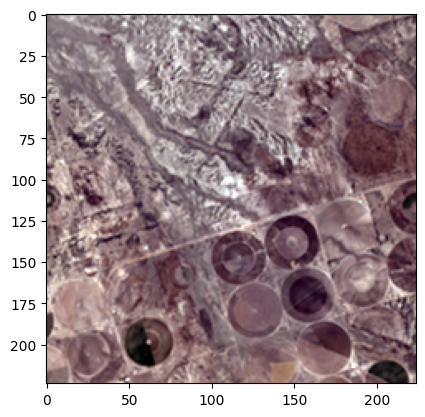

In [6]:
raster_path = "https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-demo/resolve/main/HLS.L30.T13REN.2018013T172747.v2.0.B02.B03.B04.B05.B06.B07_cropped.tif"
input_data = load_raster(raster_path, crop=(224, 224))
print(f"Input data shape is {input_data.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data)
plt.imshow(raster_for_visualization)

#### Lets call the model!
We pass:
 - The normalized input image, cropped to size (224, 224)
 - `mask_ratio`: The proportion of pixels that will be masked

The model returns a tuple with:
 - loss
 - reconstructed image
 - mask used

In [7]:
# statistics used to normalize images before passing to the model
means = np.array(train_args["data_mean"]).reshape(-1, 1, 1)
stds = np.array(train_args["data_std"]).reshape(-1, 1, 1)

def preprocess_image(image):
    # normalize image
    normalized = image.copy()
    normalized = ((image - means) / stds)
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    return normalized

In [8]:
normalized = preprocess_image(input_data)
with torch.no_grad():
        mask_ratio = 0.5
        _, pred, mask = model(normalized, mask_ratio=mask_ratio)
        mask_img = model.unpatchify(mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])).detach().cpu()
        pred_img = model.unpatchify(pred).detach().cpu()

#### Lets use these to build a nice output visualization

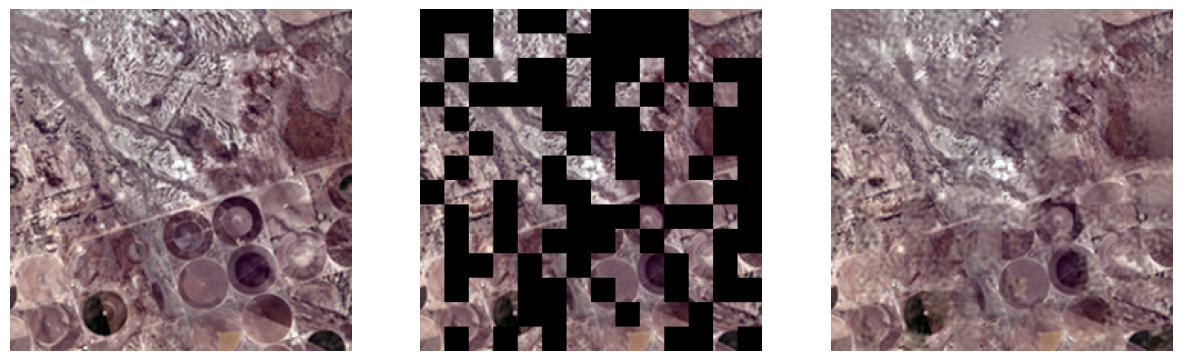

In [9]:
plot_image_mask_reconstruction(normalized, mask_img, pred_img)

## Inference with finetuned Prithvi

#### Let's explore a finetuned example - Flood Segmentation

In [10]:
from mmcv import Config
from mmseg.models import build_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile
from mmseg.apis import init_segmentor
from model_inference import inference_segmentor, process_test_pipeline
from huggingface_hub import hf_hub_download
import matplotlib
from torch import nn

In [11]:
# Grab the config and model weights from huggingface
config_path=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-sen1floods11", filename="sen1floods11_Prithvi_100M.py")
ckpt=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-sen1floods11", filename='sen1floods11_Prithvi_100M.pth')
finetuned_model = init_segmentor(Config.fromfile(config_path), ckpt, device="cuda") # Make sure to replace for "cuda" if you reserved a GPU instance

sen1floods11_Prithvi_100M.py: 100%|██████████| 7.72k/7.72k [00:00<00:00, 2.38MB/s]
sen1floods11_Prithvi_100M.pth: 100%|██████████| 1.20G/1.20G [00:32<00:00, 36.9MB/s]
/opt/conda/envs/myenv/lib/python3.9/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/myenv/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /home/jovyan/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-100M-sen1floods11/snapshots/220f62f00f6a31a70daac7babf139e4bf265f1c0/sen1floods11_Prithvi_100M.pth


### Let's grab an image to do inference on

The following images URL's are valid for exploration. Make sure to use the appropiate file name in the subsequent cells of code.

- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif`
- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/USA_430764_S2Hand.tif`
- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/India_900498_S2Hand.tif`

In [12]:
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif

--2024-02-22 02:23:01--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-sen1floods11-demo/resolve/main/Spain_7370579_S2Hand.tif
Resolving huggingface.co (huggingface.co)... 18.155.173.122, 18.155.173.45, 18.155.173.64, ...
Connecting to huggingface.co (huggingface.co)|18.155.173.122|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f5/58/f558b73cabb08f1c54cb2db126d55670236aeb76a5eac5a5e63e5fb296eb1f5a/16e997e6a7159fa11160faf00591da763eb37ac82faf806f7fe733991944a048?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Spain_7370579_S2Hand.tif%3B+filename%3D%22Spain_7370579_S2Hand.tif%22%3B&response-content-type=image%2Ftiff&Expires=1708827782&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODgyNzc4Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mNS81OC9mNTU4YjczY2FiYjA4ZjFjNTRjYjJkYjEyNmQ1NTY3MDIzNmFlYjc2YTVlYWM1YTVlNjNlNWZiMjk2ZWIx

Image input shape is (6, 512, 512)


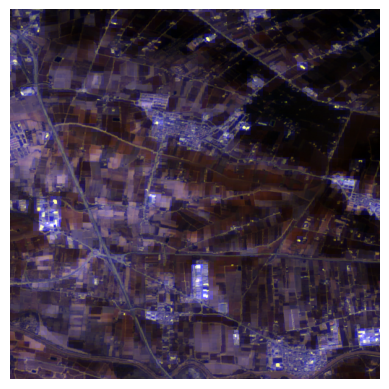

In [13]:
input_data_inference = load_raster("Spain_7370579_S2Hand.tif") # Replace according to the grabbed image
print(f"Image input shape is {input_data_inference.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data_inference)
plt.axis('off')
plt.imshow(raster_for_visualization)

In [14]:
# adapt this pipeline for Tif files with > 3 images
custom_test_pipeline = process_test_pipeline(finetuned_model.cfg.data.test.pipeline)
result = inference_segmentor(finetuned_model, "Spain_7370579_S2Hand.tif", 
                             custom_test_pipeline=custom_test_pipeline) # Replace according to the grabbed image

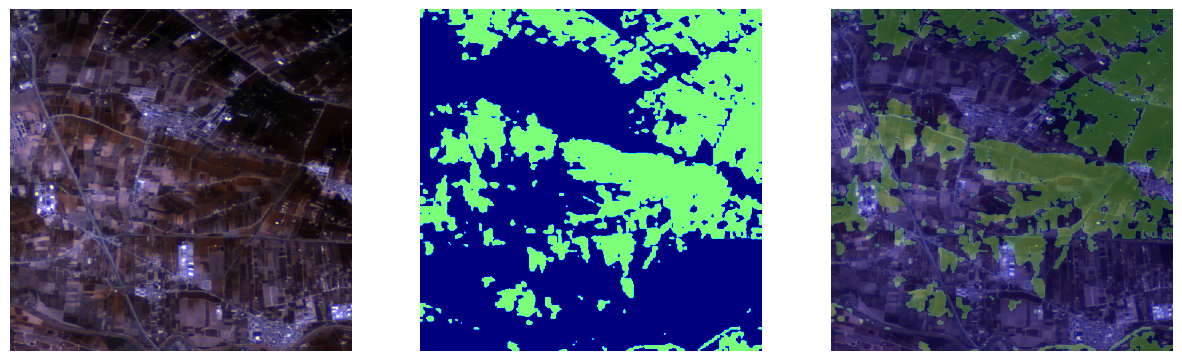

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
input_data_inference = load_raster("Spain_7370579_S2Hand.tif") # Replace according to the grabbed image
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
ax[0].imshow(enhance_raster_for_visualization(input_data_inference))
ax[1].imshow(result[0], norm=norm, cmap="jet")
ax[2].imshow(enhance_raster_for_visualization(input_data_inference))
ax[2].imshow(result[0], cmap="jet", alpha=0.3, norm=norm)
for subplot in ax:
    subplot.axis('off')

#### Burn Scrars Segmentation

In [16]:
# Grab the config and model weights from huggingface
config_path=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-burn-scar", filename="burn_scars_Prithvi_100M.py")
ckpt=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-burn-scar", filename='burn_scars_Prithvi_100M.pth')
finetuned_model = init_segmentor(Config.fromfile(config_path), ckpt, device="cuda") # Make sure to replace for "cuda" if you reserved a GPU instance

burn_scars_Prithvi_100M.py: 100%|██████████| 6.54k/6.54k [00:00<00:00, 4.78MB/s]
burn_scars_Prithvi_100M.pth: 100%|██████████| 1.20G/1.20G [00:07<00:00, 154MB/s] 
/opt/conda/envs/myenv/lib/python3.9/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


load checkpoint from local path: /home/jovyan/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-100M-burn-scar/snapshots/d8c0ec47558201ae4c79f85ff58ffaf42bb56d98/burn_scars_Prithvi_100M.pth


#### Grabbing an image

The following images URL's are valid for exploration. Make sure to use the appropiate file name in the subsequent cells of code.

- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif`
- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2018285.v1.4_merged.tif`
- `https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10UGV.2020218.v1.4_merged.tif`

In [17]:
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif

--2024-02-22 02:23:21--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo/resolve/main/subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif
Resolving huggingface.co (huggingface.co)... 18.244.202.60, 18.244.202.118, 18.244.202.73, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/1c/09/1c0948cc618defc1284e350591d02a434dcb4e42e8be4eb411c4ccbaae569c03/d4391bef26e6fe7831c9a068a8620eebb21580e17e7430dadac274b6735eef46?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif%3B+filename%3D%22subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif%22%3B&response-content-type=image%2Ftiff&Expires=1708827801&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODgyNzgwMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXB

Image input shape is (6, 512, 512)


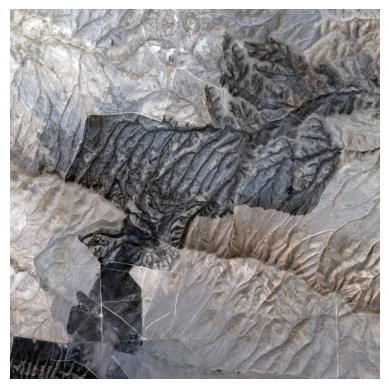

In [18]:
input_data_inference = load_raster("subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif") # Replace according to the grabbed image
print(f"Image input shape is {input_data_inference.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data_inference)
plt.axis('off')
plt.imshow(raster_for_visualization)

In [19]:
# adapt this pipeline for Tif files with > 3 images
custom_test_pipeline = process_test_pipeline(finetuned_model.cfg.data.test.pipeline)
result = inference_segmentor(finetuned_model, 
                             "subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif", 
                             custom_test_pipeline=custom_test_pipeline) # Replace according to the grabbed image

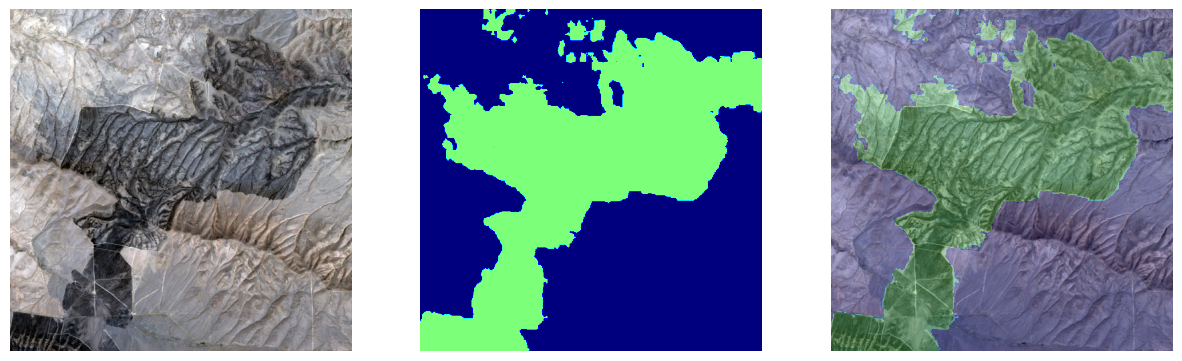

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
input_data_inference = load_raster("subsetted_512x512_HLS.S30.T10TGS.2020245.v1.4_merged.tif") # Replace according to the grabbed image
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
ax[0].imshow(enhance_raster_for_visualization(input_data_inference))
ax[1].imshow(result[0], norm=norm, cmap="jet")
ax[2].imshow(enhance_raster_for_visualization(input_data_inference))
ax[2].imshow(result[0], cmap="jet", alpha=0.3, norm=norm)
for subplot in ax:
    subplot.axis('off')

#### Multi Temporal Crop Classification

In [21]:
config_path=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification", 
                            filename="multi_temporal_crop_classification_Prithvi_100M.py")
ckpt=hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification", 
                     filename='multi_temporal_crop_classification_Prithvi_100M.pth')
finetuned_model = init_segmentor(Config.fromfile(config_path), ckpt, device="cuda")

(…)oral_crop_classification_Prithvi_100M.py: 100%|██████████| 7.08k/7.08k [00:00<00:00, 4.09MB/s]
(…)ral_crop_classification_Prithvi_100M.pth: 100%|██████████| 1.68G/1.68G [00:42<00:00, 39.4MB/s]


load checkpoint from local path: /home/jovyan/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-100M-multi-temporal-crop-classification/snapshots/3b8de5aa922c79b4cf69d497732fcf22f0edd8c6/multi_temporal_crop_classification_Prithvi_100M.pth


#### Grabbing an image

The following images URL's are valid for exploration. Make sure to use the appropiate file name in the subsequent cells of code.

- https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo/resolve/main/chip_102_345_merged.tif
- https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo/resolve/main/chip_104_104_merged.tif
- https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo/resolve/main/chip_109_421_merged.tif

In [22]:
!wget https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo/resolve/main/chip_102_345_merged.tif

--2024-02-22 02:24:16--  https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo/resolve/main/chip_102_345_merged.tif
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f3/e6/f3e6c265c07090420b89493c2d16e12b6c9303fe1ef3d7cca5c74a296793a6c7/94c99f8d76093a21587c5a8757fcdae7bb054b2586b51fc570aef5b17fc3a591?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27chip_102_345_merged.tif%3B+filename%3D%22chip_102_345_merged.tif%22%3B&response-content-type=image%2Ftiff&Expires=1708827856&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODgyNzg1Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mMy9lNi9mM2U2YzI2NWMwNzA5MDQyMGI4OTQ5M2MyZDE2ZTEyYjZjOTMwM2ZlMWVmM2Q3Y2N

Image input shape is (6, 224, 224)


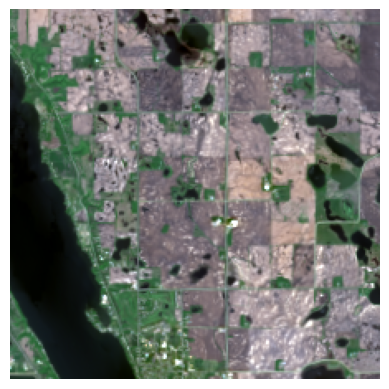

In [23]:
input_data_inference = load_raster("chip_102_345_merged.tif") # Replace according to the grabbed image
print(f"Image input shape is {input_data_inference.shape}")
raster_for_visualization = enhance_raster_for_visualization(input_data_inference)
plt.axis('off')
plt.imshow(raster_for_visualization)

In [24]:
custom_test_pipeline = process_test_pipeline(finetuned_model.cfg.data.test.pipeline)
result = inference_segmentor(finetuned_model, "chip_102_345_merged.tif", 
                             custom_test_pipeline=custom_test_pipeline) # Replace according to the grabbed image

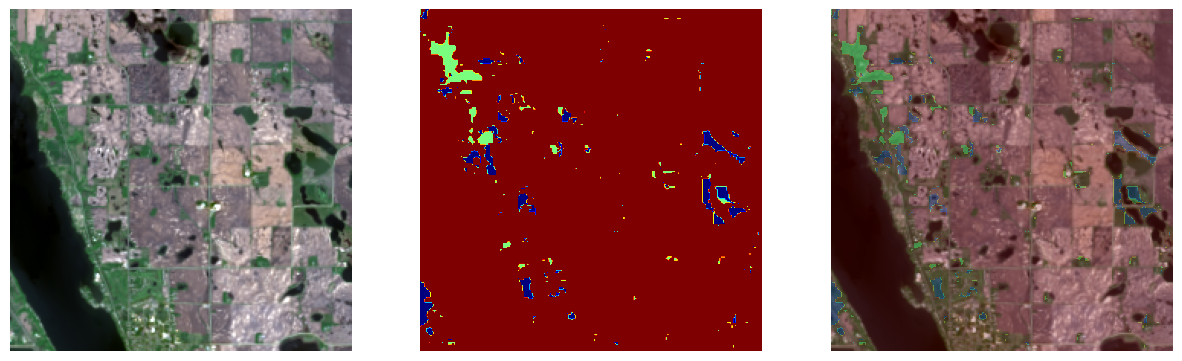

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
input_data_inference = load_raster("chip_102_345_merged.tif") # Replace according to the grabbed image
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
ax[0].imshow(enhance_raster_for_visualization(input_data_inference))
ax[1].imshow(result[0], norm=norm, cmap="jet")
ax[2].imshow(enhance_raster_for_visualization(input_data_inference))
ax[2].imshow(result[0], cmap="jet", alpha=0.3, norm=norm)
for subplot in ax:
    subplot.axis('off')

## Part 2 - Replicating finetuning 

We can replicate the finetune process for the burn scars case. First, we need to download the data. The following cell will grab the data, extract the training and validatiton sets, and create a `burn-scars-data` folder to place the extracted files.

In [26]:
import requests
from tqdm.auto import tqdm
import tarfile
import shutil

url = "https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars/resolve/main/hls_burn_scars.tar.gz"
file_path = "hls_burn_scars.tar.gz"

response = requests.get(url, stream=True) 
with open(file_path, "wb") as f:
    total_length = int(response.headers.get('content-length'))
    for data in tqdm(response.iter_content(chunk_size=4096), total=int(total_length/4096), desc="Downloading"):
        f.write(data)

with tarfile.open(file_path) as tar:
    tar.extractall()

new_dir_path = "burn-scars-data"
os.makedirs(new_dir_path, exist_ok=True)

for folder_name in ['training', 'validation']:
    shutil.move(folder_name, os.path.join(new_dir_path, folder_name))

os.remove(file_path)

Downloading: 645887it [00:24, 25964.67it/s]                            


#### Running the finetuning
With the data downloaded, we can now proceed to finetune the model. It is important to have reserved a GPU instance to be able to run the following cells of code. Take in consideration that it should take between 3-4 hours to complete the finetuning. 

The weights will be saved in the demo folder. To change the parameter specification, or the name of the destination folder, edit `configs/burn_scars.py`.

In [29]:
os.environ['PATH'] = '/opt/conda/envs/myenv/bin:' + os.environ['PATH']
!mim train mmsegmentation configs/burn_scars.py

Training command is /opt/conda/envs/myenv/bin/python3.9 /opt/conda/envs/myenv/lib/python3.9/site-packages/mmseg/.mim/tools/train.py configs/burn_scars.py --launcher none --gpus 1. 
/opt/conda/envs/myenv/lib/python3.9/site-packages/mmseg/.mim/tools/train.py:136: UserWarning: `--gpus` is deprecated because we only support single GPU mode in non-distributed training. Use `gpus=1` now.
  warnings.warn('`--gpus` is deprecated because we only support '
2024-02-22 02:30:56,238 - mmseg - INFO - Multi-processing start method is `None`
2024-02-22 02:30:56,239 - mmseg - INFO - OpenCV num_threads is `1
2024-02-22 02:30:56,299 - mmseg - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) [GCC 12.3.0]
CUDA available: True
GPU 0: NVIDIA GeForce RTX 2080 Ti
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 12.3, V12.3.107
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 

## Part 3 - Finetuning for your use case
To finetune, you can now write a PyTorch loop as usual to train on your dataset. Simply extract the backbone from the model with some surgery and run only the model features forward, with no masking!

 In general some reccomendations are:
- At least in the beggining, experiment with freezing the backbone. This will give you much faster iteration through experiments.
- Err on the side of a smaller learning rate
- With an unfrozen encoder, regularization is your friend! (Weight decay, dropout, batchnorm...)

In [ ]:
# if going with plain pytorch:
# - remember to normalize images beforehand (find the normalization statistics in the config file)
# - turn off masking by passing mask_ratio = 0
normalized = preprocess_image(input_data)
features, _, _ = model.forward_encoder(normalized, mask_ratio=0)

#### What do these features look like?
These are the standard output of a ViT.
- Dim 1: Batch size
- Dim 2: [`cls_token`] + tokens representing flattened image
- Dim 3: embedding dimension

First reshape features into "image-like" shape:
- Drop cls_token
- reshape into HxW shape

In [ ]:
print(f"Encoder features have shape {features.shape}")

# drop cls token
reshaped_features = features[:, 1:, :]

# reshape
feature_img_side_length = int(np.sqrt(reshaped_features.shape[1]))
reshaped_features = reshaped_features.view(-1, feature_img_side_length, feature_img_side_length, model_args["embed_dim"])
# channels first
reshaped_features = reshaped_features.permute(0, 3, 1, 2)
print(f"Encoder features have new shape {reshaped_features.shape}")

#### Example of a segmentation head
A simple segmentation head can consist of a few upscaling blocks + a final head for classification

In [ ]:
num_classes = 2
upscaling_block = lambda in_channels, out_channels: nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, padding=1), nn.ReLU())
embed_dims = [model_args["embed_dim"] // (2**i) for i in range(5)]
segmentation_head = nn.Sequential(
    *[
    upscaling_block(embed_dims[i], embed_dims[i+1]) for i in range(4)
    ],
    nn.Conv2d(kernel_size=1, in_channels=embed_dims[-1], out_channels=num_classes))

### Running features through the segmentation head
We now get an output of shape [batch_size, num_classes, height, width]

In [ ]:
segmentation_head(reshaped_features).shape

### Finetuning - MMSeg
Alternatively, finetune using the MMSegmentation extension we have opensourced.
- No model surgery required
- No need to write boilerplate training code
- Integrations with Tensorboard, MLFlow, ...
- Segmentation evaluation metrics / losses built in

1. Build your config file. Look [here](./configs/) for examples, the [ReadME](./README.md) for some docs and [MMSeg](https://mmsegmentation.readthedocs.io/en/0.x/tutorials/config.html) for more general tutorials.
2. Collect your dataset in the format determined by MMSeg
3. `mim train mmsegmentation <path to my config>`

This is what the model looks like in the MMSeg configuration code.

All this composition we did above is done for you!
```python
model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=num_layers,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=num_frames*embed_dim,
        output_embed_dim=embed_dim,
        drop_cls_token=True,
        Hp=img_size // patch_size,
        Wp=img_size // patch_size,
    ),
    decode_head=dict(
        num_classes=num_classes,
        in_channels=embed_dim,
        type="FCNHead",
        in_index=-1,
        ignore_index=ignore_index,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type="CrossEntropyLoss",
            use_sigmoid=False,
            loss_weight=1,
            class_weight=ce_weights,
            avg_non_ignore=True
        ),
    ),
    (...)
```